In [12]:
from base_model import No_Heuristic, TabuSearch
from gurobipy import GRB
import matplotlib.pyplot as plt
import numpy as np

## Evaluation  Methods

In [13]:
def visualize_results(model, optimization_instance):
        
    if model.status != GRB.OPTIMAL:
        print("Model did not converge to an optimal solution")
    else:
        print("Model converged to an optimal solution") 
        
    # Display objective function result
    minimized_cost = model.ObjVal
    print(f"Minimized Total Cost (Objective Value): {minimized_cost}")

    # Extract start and end times for each part assigned to each machine
    start_times_values = {
        (p, m): optimization_instance.start_times[p, m].X
        for p in range(1, optimization_instance.num_parts + 1)
        for m in optimization_instance.machines
    }

    end_times_values = {
        (p, m): (optimization_instance.start_times[p, m].X + optimization_instance.demand[p] * optimization_instance.unit_production_time)
        if sum(optimization_instance.predecessor[q, p, m].X for q in range(1, optimization_instance.num_parts + 3)) == 1 else 0
        for p in range(1, optimization_instance.num_parts + 1)
        for m in optimization_instance.machines
    }

    # Define unique break intervals for each machine (start, end, shift_amount)
    breaks = {
        1: [(0, 0, 0)],  # Breaks for Machine 1
        2: [(0, 0, 0)],  # Breaks for Machine 2
    }

    # Plotting the Gantt chart with two subplots for Machine 1 and Machine 2
    fig, axs = plt.subplots(2, 1, figsize=(22, 12), sharex=True)

    # Define color mapping for the parts
    color_map = {
        'Red': 'red',
        'Blue': 'blue',
        'Green': 'green',
        'Yellow': 'yellow',
        'Black': 'black',
        'Purple': 'purple',
        'Orange': 'orange',
        'Pink': 'pink',
    }

    # Set maximum times scaled for plotting
    max_time_A = optimization_instance.max_time_machine_A
    max_time_B = optimization_instance.max_time_machine_B

    # Iterate through each machine and process parts in a sorted order
    for m in optimization_instance.machines:
        ax = axs[m - 1]  # Subplot for each machine
        cumulative_shift = 0  # Track cumulative shifts for breaks

        # Sort parts by start time for consistent plotting
        sorted_parts = sorted(
            [p for p in range(1, optimization_instance.num_parts + 1)],
            key=lambda p: start_times_values[(p, m)]
        )

        for p in sorted_parts:
            part_color = color_map[optimization_instance.parts_colors[p]]
            start = start_times_values[(p, m)]
            end = end_times_values[(p, m)]
            shifted_start = start + cumulative_shift
            shifted_end = end + cumulative_shift

            if shifted_start == shifted_end:
                continue

            # Check if the part needs to be split by any breaks
            for break_start, break_end, shift_amount in breaks[m]:
                if shifted_start < break_start < shifted_end:
                    # Plot the first segment before the break
                    ax.barh(p, break_start - shifted_start, left=shifted_start, color=part_color, edgecolor='black')

                    # Shift the second segment after the break
                    shifted_start = break_end + shift_amount
                    shifted_end += shift_amount
                    ax.barh(p, end - break_end, left=shifted_start, color=part_color, edgecolor='black')

                    # Update cumulative shift for the remaining parts
                    cumulative_shift += shift_amount
                    break  # Move to the next part after handling this break
                elif shifted_start >= break_end:
                    # Entire block is after the break; apply shift
                    shifted_start += shift_amount
                    shifted_end += shift_amount

            # Plot the adjusted (shifted) part
            ax.barh(p, shifted_end - shifted_start, left=shifted_start, color=part_color, edgecolor='black')

        if m == 1:
            ax.axvline(x=max_time_A, color='red', linestyle='--', alpha=0.8, linewidth=1.5, label="Max Time A")
            ax.legend(loc='upper left')
        elif m == 2:
            ax.axvline(x=max_time_B, color='red', linestyle='--', alpha=0.8, linewidth=1.5, label="Max Time B")
            ax.legend(loc='upper left')

        # Customize each subplot
        ax.set_title(f"Machine {m} Schedule", fontsize=16)
        ax.set_ylabel("Product Type", fontsize=14)
        ax.set_yticks(range(1, optimization_instance.num_parts + 1))
        ax.set_yticklabels([f'Type {i}' for i in range(1, optimization_instance.num_parts + 1)])
        ax.grid(axis='x', linestyle='--', alpha=0.7)

    # Set common labels
    plt.xlabel("Time (seconds)", fontsize=14)
    plt.xticks(np.arange(0, max_time_A, 4000))  # Adjust x-tick intervals for seconds

    fig.suptitle("Optimal Production Schedule for Two Machines", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout for title space

    # Save the plot as an image file
    plt.savefig("optimal_production_schedule.png")
    plt.show()

    return start_times_values, end_times_values

## Evaluations 

In [14]:
no_heuristic_model = No_Heuristic()
model, optimization_time = no_heuristic_model()

Set parameter IntFeasTol to value 1e-09
Set parameter Threads to value 8
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.2.0 24C101)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 624 rows, 312 columns and 4220 nonzeros
Model fingerprint: 0x2e3a3f9b
Variable types: 24 continuous, 288 integer (288 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+04]
Presolve removed 222 rows and 92 columns
Presolve time: 0.01s
Presolved: 402 rows, 220 columns, 4580 nonzeros
Variable types: 20 continuous, 200 integer (200 binary)

Root relaxation: objective 0.000000e+00, 37 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0  

In [15]:
no_heuristic_model.optimization_metadata

<gurobi.Model MIP instance PaintingProcessOptimization: 624 constrs, 312 vars, Parameter changes: IntFeasTol=1e-09, Threads=8>

In [16]:
no_heuristic_model.start_times

{(1, 1): <gurobi.Var self.start_times[1,1] (value 0.0)>,
 (1, 2): <gurobi.Var self.start_times[1,2] (value 12080.0)>,
 (2, 1): <gurobi.Var self.start_times[2,1] (value 0.0)>,
 (2, 2): <gurobi.Var self.start_times[2,2] (value 8080.0)>,
 (3, 1): <gurobi.Var self.start_times[3,1] (value 20160.0)>,
 (3, 2): <gurobi.Var self.start_times[3,2] (value 0.0)>,
 (4, 1): <gurobi.Var self.start_times[4,1] (value 16160.0)>,
 (4, 2): <gurobi.Var self.start_times[4,2] (value 0.0)>,
 (5, 1): <gurobi.Var self.start_times[5,1] (value 4000.0)>,
 (5, 2): <gurobi.Var self.start_times[5,2] (value 0.0)>,
 (6, 1): <gurobi.Var self.start_times[6,1] (value 0.0)>,
 (6, 2): <gurobi.Var self.start_times[6,2] (value 0.0)>,
 (7, 1): <gurobi.Var self.start_times[7,1] (value 12080.0)>,
 (7, 2): <gurobi.Var self.start_times[7,2] (value 0.0)>,
 (8, 1): <gurobi.Var self.start_times[8,1] (value 8080.0)>,
 (8, 2): <gurobi.Var self.start_times[8,2] (value 0.0)>,
 (9, 1): <gurobi.Var self.start_times[9,1] (value 0.0)>,
 (9, 2

In [17]:
print(optimization_time)

0.0607609748840332


In [18]:
# Check the number of quadratic constraints and non-zero quadratic terms in the objective
num_quadratic_constraints = model.getAttr("NumQConstrs")  # Number of quadratic constraints
num_quadratic_obj_terms = model.getAttr("NumQNZs")       # Number of non-zero quadratic terms in the objective

# Print the results to confirm linearity
print("Number of quadratic constraints:", num_quadratic_constraints)
print("Number of quadratic objective terms:", num_quadratic_obj_terms)

# Check if the model is MILP based on the absence of quadratic terms
is_milp = num_quadratic_constraints == 0 and num_quadratic_obj_terms == 0 and model.getAttr("IsMIP")
print("Model is MILP:", bool(is_milp))


Number of quadratic constraints: 0
Number of quadratic objective terms: 0
Model is MILP: True


In [19]:
no_heuristic_model.predecessor

{(1, 1, 1): <gurobi.Var self.predecessor[1,1,1] (value 0.0)>,
 (1, 1, 2): <gurobi.Var self.predecessor[1,1,2] (value 0.0)>,
 (1, 2, 1): <gurobi.Var self.predecessor[1,2,1] (value 0.0)>,
 (1, 2, 2): <gurobi.Var self.predecessor[1,2,2] (value 0.0)>,
 (1, 3, 1): <gurobi.Var self.predecessor[1,3,1] (value 0.0)>,
 (1, 3, 2): <gurobi.Var self.predecessor[1,3,2] (value 0.0)>,
 (1, 4, 1): <gurobi.Var self.predecessor[1,4,1] (value 0.0)>,
 (1, 4, 2): <gurobi.Var self.predecessor[1,4,2] (value 0.0)>,
 (1, 5, 1): <gurobi.Var self.predecessor[1,5,1] (value 0.0)>,
 (1, 5, 2): <gurobi.Var self.predecessor[1,5,2] (value 0.0)>,
 (1, 6, 1): <gurobi.Var self.predecessor[1,6,1] (value 0.0)>,
 (1, 6, 2): <gurobi.Var self.predecessor[1,6,2] (value 0.0)>,
 (1, 7, 1): <gurobi.Var self.predecessor[1,7,1] (value 0.0)>,
 (1, 7, 2): <gurobi.Var self.predecessor[1,7,2] (value 0.0)>,
 (1, 8, 1): <gurobi.Var self.predecessor[1,8,1] (value 0.0)>,
 (1, 8, 2): <gurobi.Var self.predecessor[1,8,2] (value 0.0)>,
 (1, 9, 

In [20]:
no_heuristic_model.start_times

{(1, 1): <gurobi.Var self.start_times[1,1] (value 0.0)>,
 (1, 2): <gurobi.Var self.start_times[1,2] (value 12080.0)>,
 (2, 1): <gurobi.Var self.start_times[2,1] (value 0.0)>,
 (2, 2): <gurobi.Var self.start_times[2,2] (value 8080.0)>,
 (3, 1): <gurobi.Var self.start_times[3,1] (value 20160.0)>,
 (3, 2): <gurobi.Var self.start_times[3,2] (value 0.0)>,
 (4, 1): <gurobi.Var self.start_times[4,1] (value 16160.0)>,
 (4, 2): <gurobi.Var self.start_times[4,2] (value 0.0)>,
 (5, 1): <gurobi.Var self.start_times[5,1] (value 4000.0)>,
 (5, 2): <gurobi.Var self.start_times[5,2] (value 0.0)>,
 (6, 1): <gurobi.Var self.start_times[6,1] (value 0.0)>,
 (6, 2): <gurobi.Var self.start_times[6,2] (value 0.0)>,
 (7, 1): <gurobi.Var self.start_times[7,1] (value 12080.0)>,
 (7, 2): <gurobi.Var self.start_times[7,2] (value 0.0)>,
 (8, 1): <gurobi.Var self.start_times[8,1] (value 8080.0)>,
 (8, 2): <gurobi.Var self.start_times[8,2] (value 0.0)>,
 (9, 1): <gurobi.Var self.start_times[9,1] (value 0.0)>,
 (9, 2

In [21]:
# Check if the model is infeasible
if model.status == GRB.INFEASIBLE:
    print("Model is infeasible. Computing IIS...")
    model.computeIIS()
    model.write("model.ilp")
    
    # Print the constraints that are part of the IIS
    print("\nThe following constraints are part of the IIS:")
    for c in model.getConstrs():
        if c.IISConstr:
            print(f"{c.constrName}")

Model converged to an optimal solution
Minimized Total Cost (Objective Value): 3.0


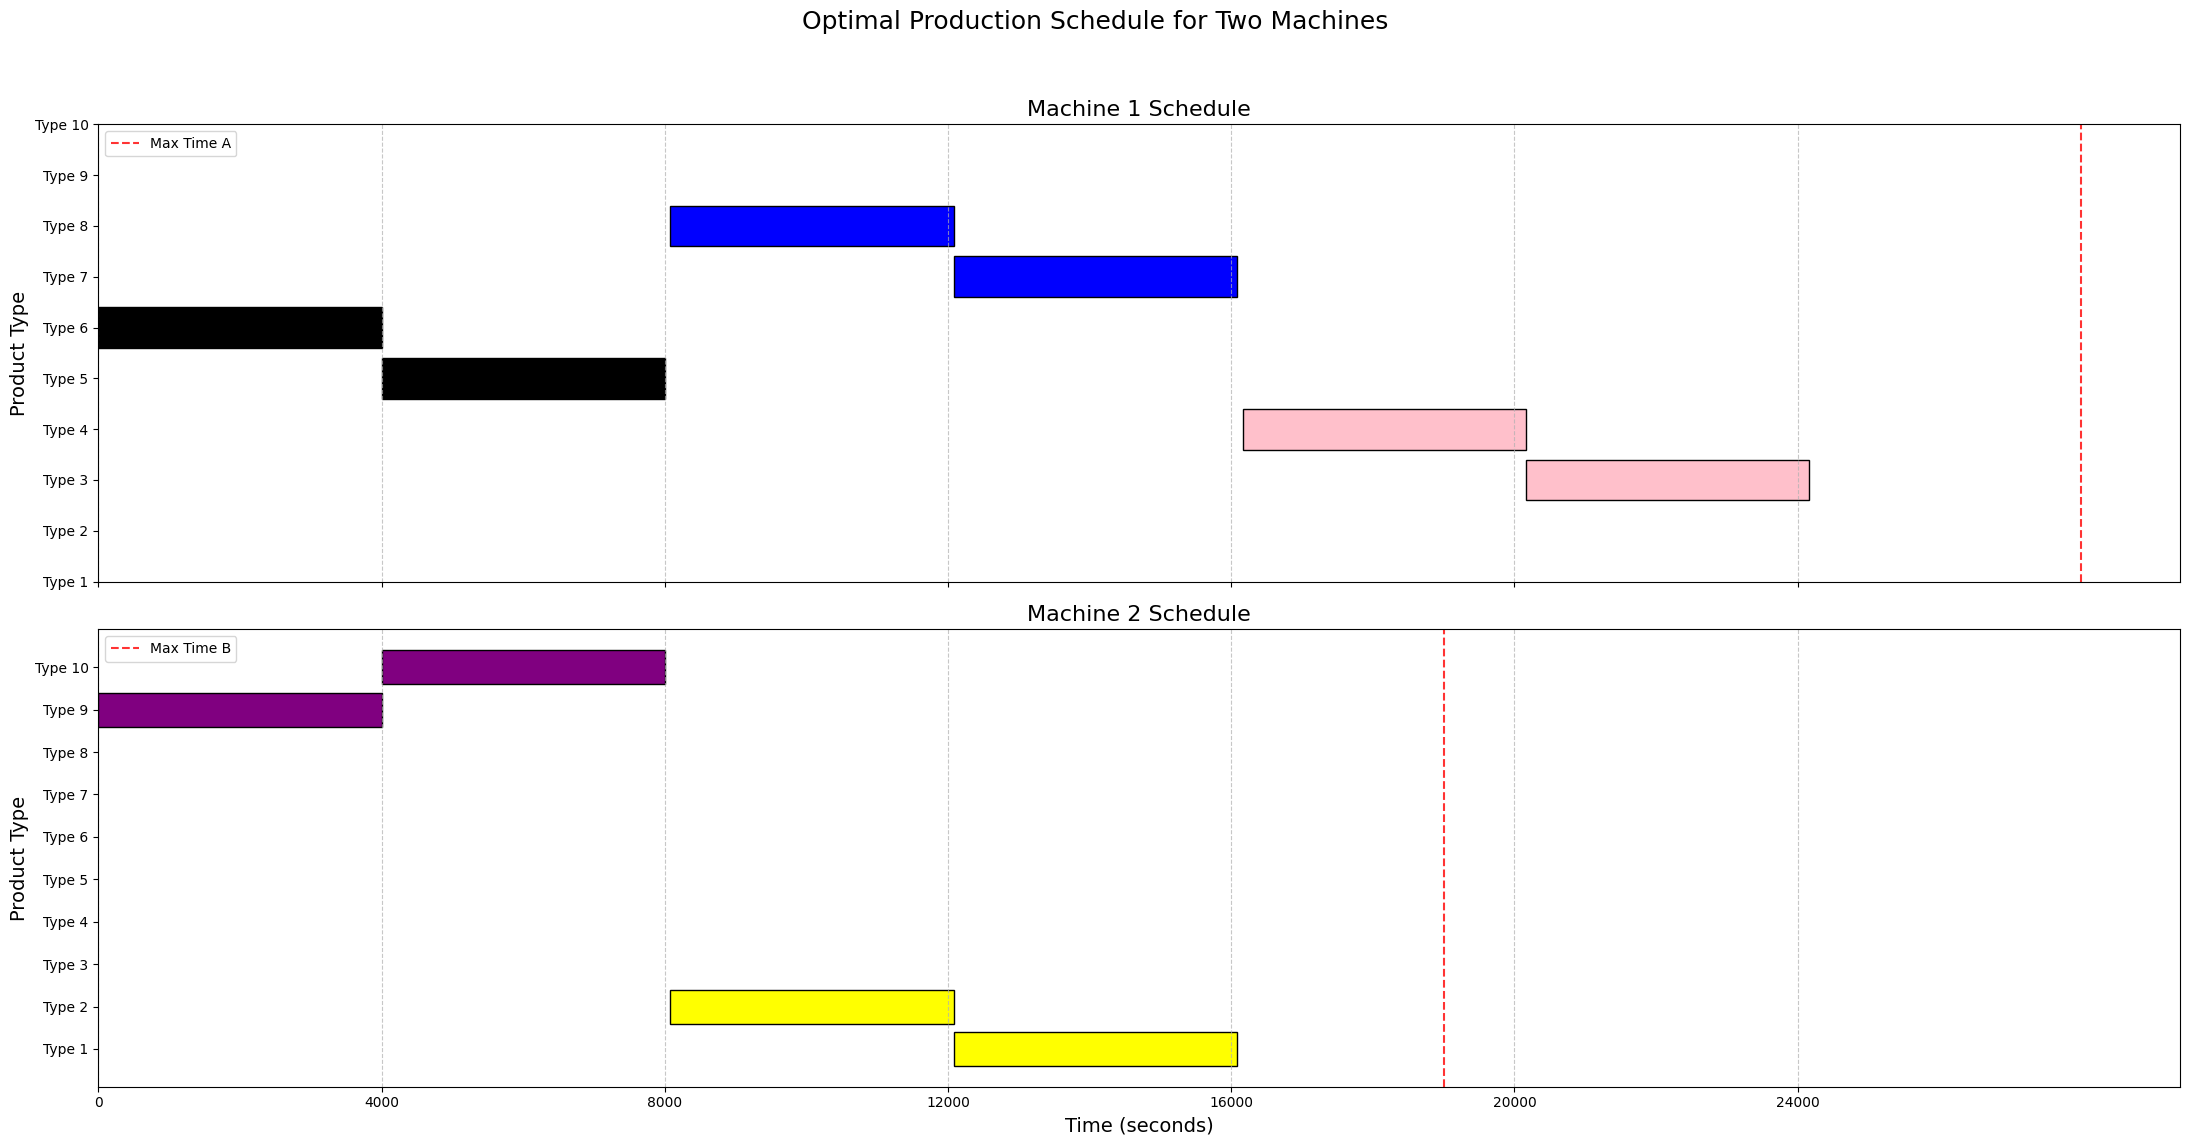

In [22]:
start_times_values, end_times_values = visualize_results(model, no_heuristic_model)